<a href="https://colab.research.google.com/github/FionaVrt/M1-Spe-AI/blob/main/rendu_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# =========================
# IMPORTS
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# =========================
# CHARGEMENT DES DONNÉES
# =========================
df = pd.read_csv("amazon_review.csv")
df.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


In [17]:
#Analyse statistique des données

# Informations générales
df.info()

# Valeurs manquantes
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      4915 non-null   object 
 1   asin            4915 non-null   object 
 2   reviewerName    4914 non-null   object 
 3   helpful         4915 non-null   object 
 4   reviewText      4914 non-null   object 
 5   overall         4915 non-null   float64
 6   summary         4915 non-null   object 
 7   unixReviewTime  4915 non-null   int64  
 8   reviewTime      4915 non-null   object 
 9   day_diff        4915 non-null   int64  
 10  helpful_yes     4915 non-null   int64  
 11  total_vote      4915 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 460.9+ KB


,0
reviewerID,0
asin,0
reviewerName,1
helpful,0
reviewText,1
overall,0
summary,0
unixReviewTime,0
reviewTime,0
day_diff,0


In [19]:
df = df.dropna(subset=["reviewText"])


In [20]:
# Suppression des avis neutres (note = 3)
df = df[df["overall"] != 3]

# Création du label sentiment
df["sentiment"] = df["overall"].apply(lambda x: 1 if x >= 4 else 0)

df["sentiment"].value_counts()


,count
sentiment,
1,4448
0,324


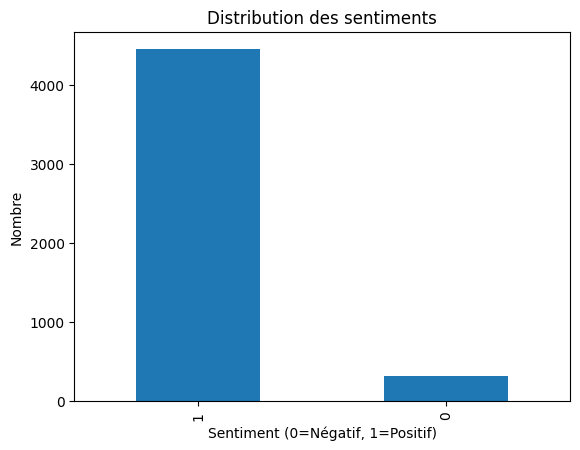

In [21]:
#Distribution des sentiments

df["sentiment"].value_counts().plot(kind="bar")
plt.title("Distribution des sentiments")
plt.xlabel("Sentiment (0=Négatif, 1=Positif)")
plt.ylabel("Nombre")
plt.show()


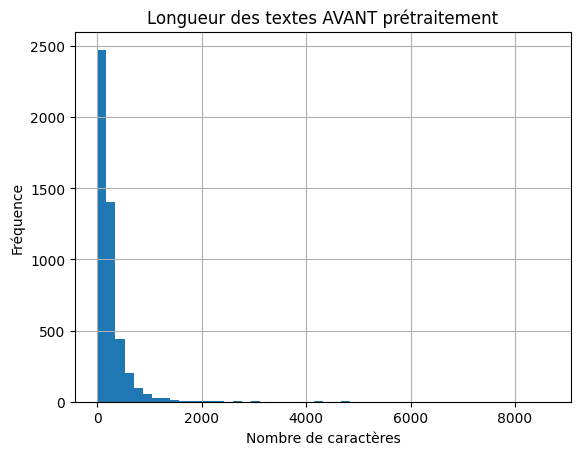

In [22]:
#Longueur des textes – AVANT prétraitement

df["text_length_raw"] = df["reviewText"].str.len()

df["text_length_raw"].hist(bins=50)
plt.title("Longueur des textes AVANT prétraitement")
plt.xlabel("Nombre de caractères")
plt.ylabel("Fréquence")
plt.show()


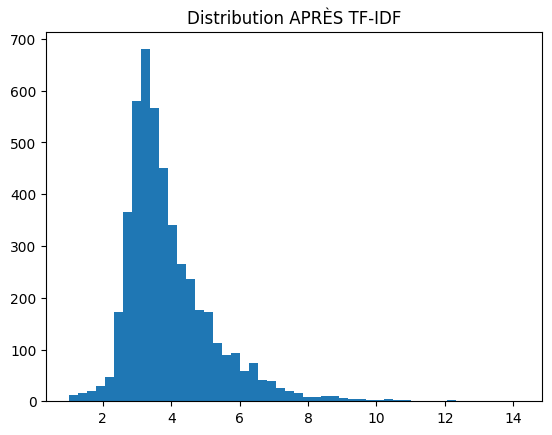

In [23]:
#Normalisation / standardisation
# Vectorisation TF-IDF
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
X_tfidf = tfidf.fit_transform(df["reviewText"])

# Longueur des vecteurs (APRÈS)
vector_lengths = X_tfidf.sum(axis=1)

plt.hist(np.array(vector_lengths).flatten(), bins=50)
plt.title("Distribution APRÈS TF-IDF")
plt.show()


In [24]:
#Séparation Train / Validation / Test
X = df["reviewText"]
y = df["sentiment"]

# 70% train, 30% temporaire
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 15% validation, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train :", len(X_train))
print("Validation :", len(X_val))
print("Test :", len(X_test))


Train : 3340
Validation : 716
Test : 716


# **2. MODÈLES**

In [25]:
#Régression Logistique

pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LogisticRegression(max_iter=1000))
])

param_lr = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "clf__C": [0.1, 1, 10]
}

gs_lr = GridSearchCV(pipe_lr, param_lr, cv=3, scoring="f1")
gs_lr.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'clf__C': [0.1, 1, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1')

# **Modèle 2 – Naive Bayes**

In [26]:
pipe_nb = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", MultinomialNB())
])

param_nb = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "clf__alpha": [0.5, 1.0]
}

gs_nb = GridSearchCV(pipe_nb, param_nb, cv=3, scoring="f1")
gs_nb.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf', MultinomialNB())]),
             param_grid={'clf__alpha': [0.5, 1.0],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1')

# **ÉVALUATION ET COMPARAISON**

In [27]:
#Métriques

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred)
    }

results = pd.DataFrame({
    "Logistic Regression": evaluate(gs_lr, X_test, y_test),
    "Naive Bayes": evaluate(gs_nb, X_test, y_test)
}).T

results


,Accuracy,Precision,Recall,F1-score
Logistic Regression,0.956704,0.959538,0.995502,0.977189
Naive Bayes,0.931564,0.931564,1.000000,0.964570


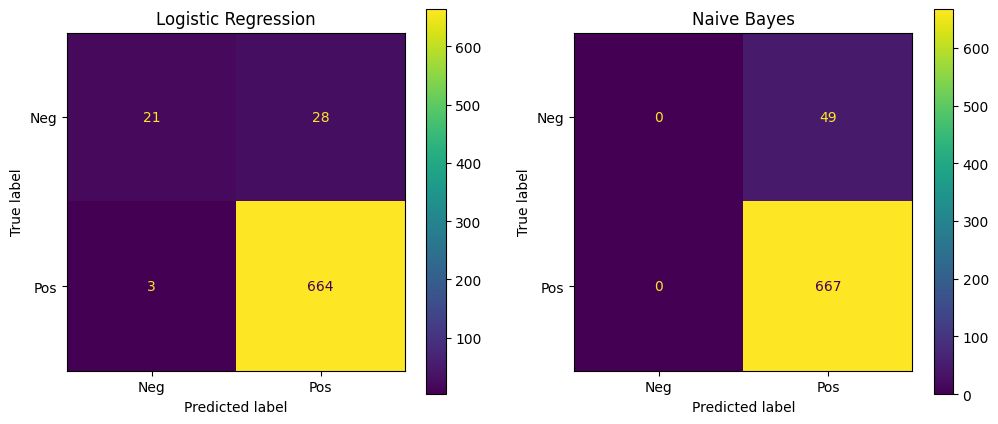

In [28]:
#Matrices de confusion

fig, axes = plt.subplots(1, 2, figsize=(12,5))

ConfusionMatrixDisplay(
    confusion_matrix(y_test, gs_lr.predict(X_test)),
    display_labels=["Neg", "Pos"]
).plot(ax=axes[0])
axes[0].set_title("Logistic Regression")

ConfusionMatrixDisplay(
    confusion_matrix(y_test, gs_nb.predict(X_test)),
    display_labels=["Neg", "Pos"]
).plot(ax=axes[1])
axes[1].set_title("Naive Bayes")

plt.show()


In [29]:
#Surapprentissage

pd.DataFrame({
    "Train": [
        accuracy_score(y_train, gs_lr.predict(X_train)),
        accuracy_score(y_train, gs_nb.predict(X_train))
    ],
    "Test": [
        accuracy_score(y_test, gs_lr.predict(X_test)),
        accuracy_score(y_test, gs_nb.predict(X_test))
    ]
}, index=["Logistic Regression", "Naive Bayes"])


,Train,Test
Logistic Regression,0.998204,0.956704
Naive Bayes,0.935329,0.931564


# **POST-PROCESSING**

In [30]:
#Amélioration

pipe_lr_improved = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        max_features=10000,
        ngram_range=(1,2)
    )),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

pipe_lr_improved.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [31]:
#Comparaison AVANT / APRÈS

before = evaluate(gs_lr, X_test, y_test)
after = evaluate(pipe_lr_improved, X_test, y_test)

pd.DataFrame([before, after], index=["Avant", "Après"])


,Accuracy,Precision,Recall,F1-score
Avant,0.956704,0.959538,0.995502,0.977189
Après,0.953911,0.983232,0.967016,0.975057


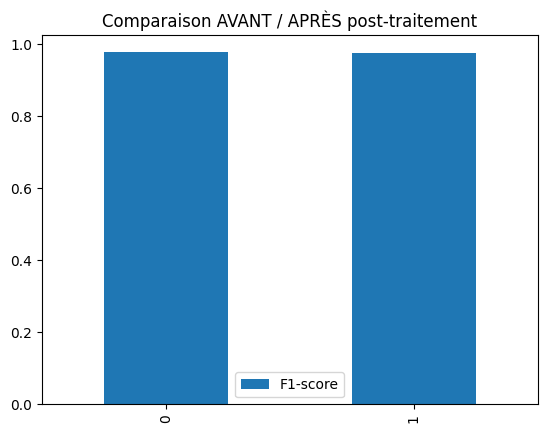

In [32]:
pd.DataFrame([before, after])[["F1-score"]].plot(kind="bar")
plt.title("Comparaison AVANT / APRÈS post-traitement")
plt.show()
